## Kunskapskontroll 2
### Arina Godman

# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential

from keras.optimizers import Adam,SGD,RMSprop

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.utils import class_weight

from google.colab import files

För att kunna importera dataset direkt från Kaggle ska vi använda opedatasets-biblioteket

# Importing Dataset

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

Min token från Kaggle: {"username":"arinagodman","key":"aa554585cf0998ee942c58e1942417f3"}

In [ ]:
od.download("https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset")

Skipping, found downloaded files in "./face-expression-recognition-dataset" (use force=True to force download)


# Displaying Pictures

In [ ]:
picture_size = 48
folder_path = "./face-expression-recognition-dataset/images/"

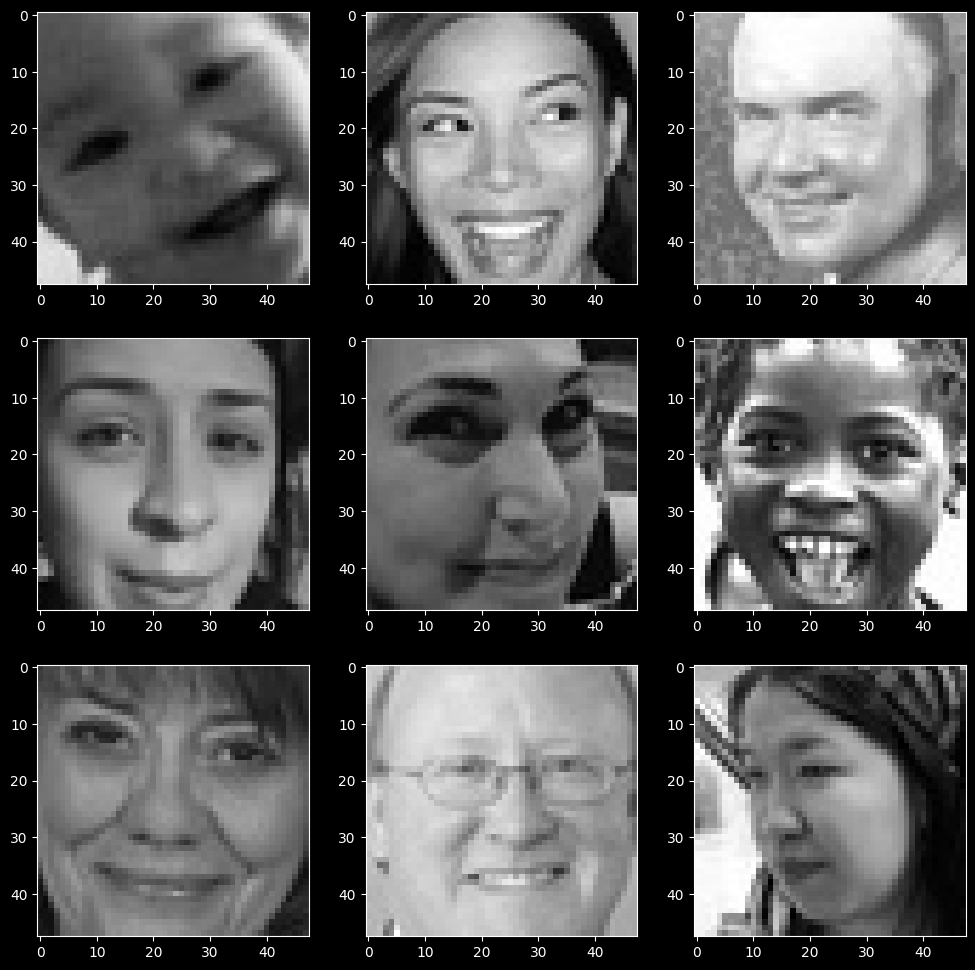

In [ ]:
expression = 'happy'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

In [ ]:
for expression in os.listdir(folder_path + "train"):
    print(str(len(os.listdir(folder_path + "train/" + expression))) + " " + expression + " images")

4103 fear images
3205 surprise images
7164 happy images
3993 angry images
436 disgust images
4982 neutral images
4938 sad images


# Training av Validation Data

In [ ]:
batch_size  = 128

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Building a model

In [ ]:
no_of_classes = 7

model = Sequential()

# 1st CNN layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd CNN layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd CNN layer
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th CNN layer
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
# Fully connected layers
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

In [ ]:
# Compute class weights for better predictions
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_set.classes),
    y=train_set.classes
)

class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_16 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 128)      

# Fitting the Model with Training and Validation Data

In [ ]:
checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    class_weight=class_weights,
    callbacks=callbacks_list
)

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 2.0514 - accuracy: 0.1724
Epoch 1: val_accuracy improved from -inf to 0.01577, saving model to ./model.h5
225/225 [==============================] - 42s 166ms/step - loss: 2.0514 - accuracy: 0.1724 - val_loss: 2.0993 - val_accuracy: 0.0158 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.9670 - accuracy: 0.1891
Epoch 2: val_accuracy did not improve from 0.01577
225/225 [==============================] - 26s 116ms/step - loss: 1.9670 - accuracy: 0.1891 - val_loss: 2.1782 - val_accuracy: 0.0158 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.9045 - accuracy: 0.2142
Epoch 3: val_accuracy improved from 0.01577 to 0.15028, saving model to ./model.h5
225/225 [==============================] - 28s 123ms/step - loss: 1.9045 - accuracy: 0.2142 - val_loss: 1.9264 - val_accuracy: 0.1503 - lr: 0.0010
Epoch 4/50
225/225 [==============================] - ETA: 0s - loss: 1.8372 - accuracy: 0.2433
Epoch 4: val_accuracy improved from 0.15028 to 0.22202, saving model to ./model.h5
225/225 [==============================] - 26s 115ms/step - loss: 1.8372 - accuracy: 0.2433 - val_loss: 1.8543 - val_accuracy: 0.2220 - lr: 0.0010
Epoch 5/50
225/225 [==============================] - 

# Plotting Accuracy & Loss

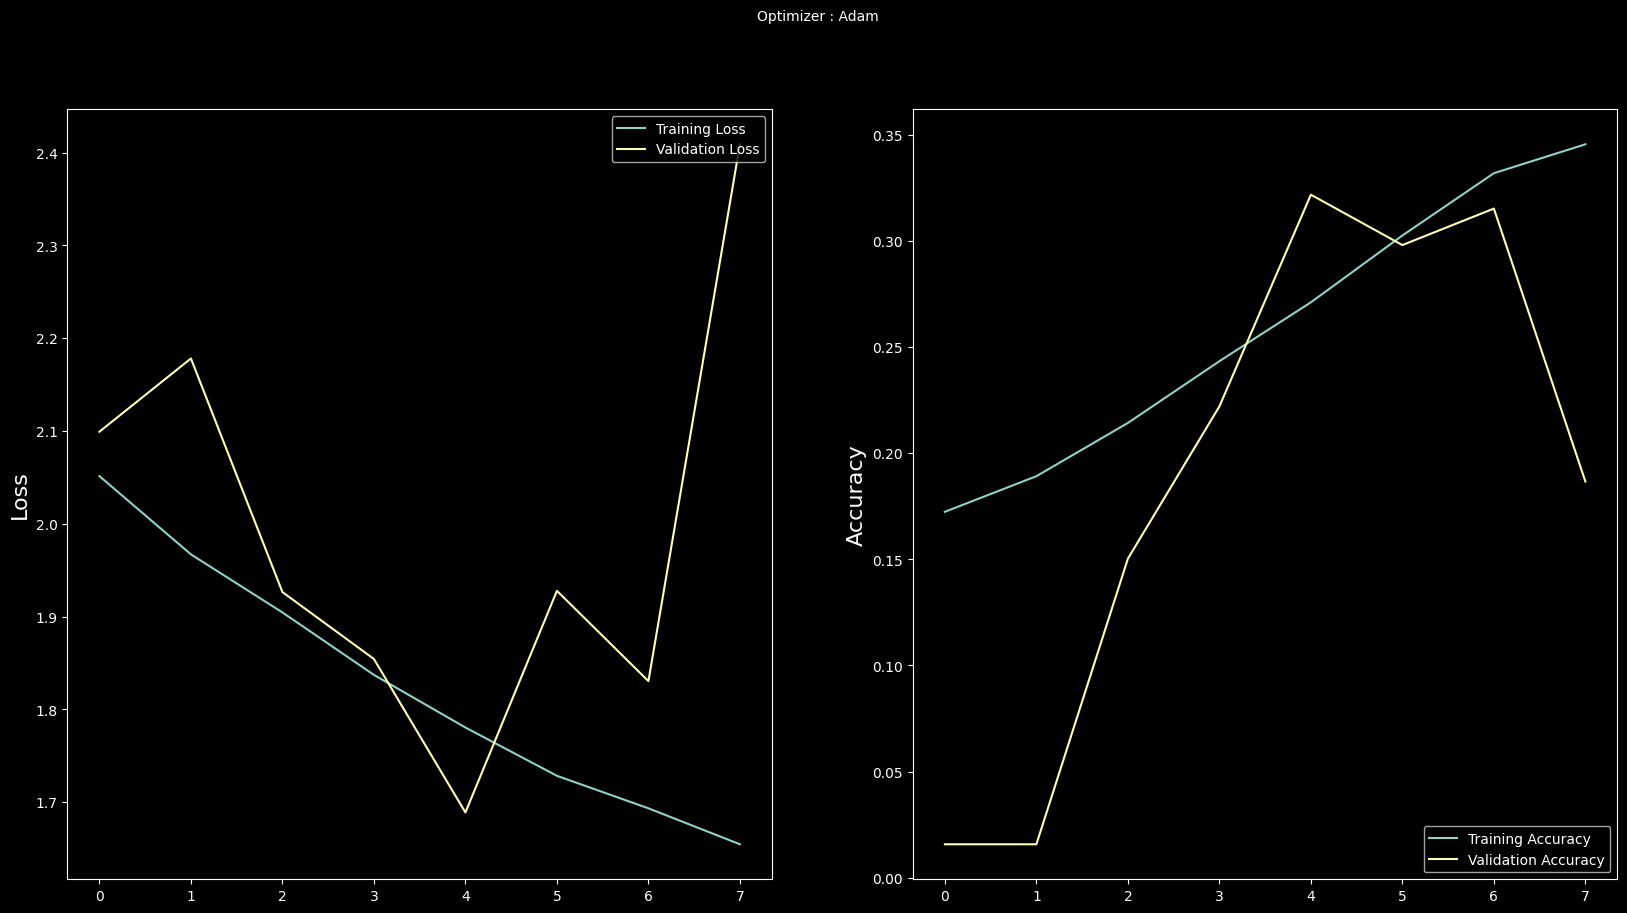

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
files.download('model.h5')

# Trying a model without early stopping

In [ ]:
model_1= Sequential()

model_1.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model_1.add(Conv2D(256, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(Conv2D(512, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(GlobalAveragePooling2D())

model_1.add(Dense(256))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.25))

model_1.add(Dense(no_of_classes, activation='softmax'))

In [ ]:
epochs = 50

model_1.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
model_1.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    class_weight=class_weights
)

Epoch 1/50
225/225 [==============================] - 34s 125ms/step - loss: 2.0509 - accuracy: 0.1733 - val_loss: 1.8837 - val_accuracy: 0.2592
Epoch 2/50
225/225 [==============================] - 26s 114ms/step - loss: 1.9624 - accuracy: 0.1969 - val_loss: 2.0730 - val_accuracy: 0.0396
Epoch 3/50
225/225 [==============================] - 26s 114ms/step - loss: 1.8806 - accuracy: 0.2288 - val_loss: 2.0699 - val_accuracy: 0.2047
Epoch 4/50
225/225 [==============================] - 26s 115ms/step - loss: 1.8111 - accuracy: 0.2607 - val_loss: 1.9462 - val_accuracy: 0.2170
Epoch 5/50
225/225 [==============================] - 26s 114ms/step - loss: 1.7473 - accuracy: 0.2982 - val_loss: 1.6615 - val_accuracy: 0.3472
Epoch 6/50
225/225 [==============================] - 26s 115ms/step - loss: 1.6991 - accuracy: 0.3246 - val_loss: 1.7660 - val_accuracy: 0.3071
Epoch 7/50
225/225 [==============================] - 26s 115ms/step - loss: 1.6391 - accuracy: 0.3583 - val_loss: 1.4651 - val_ac

In [ ]:
model_1.save('my_model.h5')
files.download('my_model.h5')